# Figure C: the tolerance parameter for Huron's typology

In this notebook we search for the value of the tolerance parameter for which Huron's typology has maximal entropy.
That is, for which the classes are as big as possible. We do do this by a simple grid search.

In [3]:
# Import 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets

matplotlib.style.use('styles.mplstyle')

from src.typology import HuronTypology, Contour, TypologyOptimizer
# from melodic_contour import *

In [2]:
dfs, contours = load_datasets()

## Estimate tolerance on cross-cultural dataset

In [58]:
# Combined dataset of 5000 sampled contours
combined_contours = []
dataset_ids = ['erk', 'boehme', 'han', 'natmin', 'liber-antiphons', 'liber-responsories']
for dataset_id in dataset_ids:
    combined_contours.extend([Contour(pitches) for pitches in contours[dataset_id][:5000]])
    
np.random.shuffle(combined_contours)
combined_contours = combined_contours[:5000]

In [59]:
# Optimize the typology
huron_optimizer = TypologyOptimizer(HuronTypology)
loss_fn = huron_optimizer.loss_function(combined_contours, ['tolerance'])

best, res = huron_optimizer.optimize(combined_contours, dict(tolerance=[0, 10]))
best_entropy = -1*res['fun']
best_epsilon = best['tolerance']

xs = np.linspace(0, 10, 50)
losses = [-1*loss_fn([x]) for x in xs]

In [60]:
best_epsilon

1.315063312810798

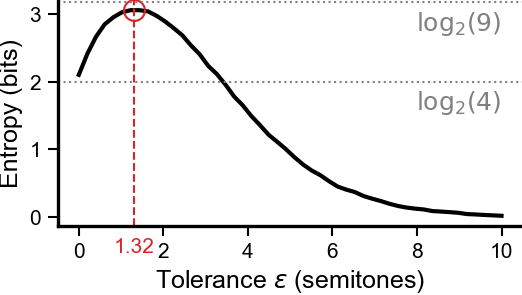

In [61]:
def show_entropy(xs, losses, best_epsilon, best_entropy):
    plt.plot(xs, losses, 'k-', lw=1)
    plt.plot(best_epsilon, best_entropy, 'o', markerfacecolor="None", ms=5, color='C3', markeredgewidth=.5)
    plt.axvline(best_epsilon, ls='--', color='C3', lw=.5, label='optimal $\epsilon$ for erk')
    plt.gca().text(best_epsilon, -.3, f'{best_epsilon:.2f}', color='C3', va='top', ha='center', size=5)

    plt.ylabel('Entropy (bits)')
    plt.xlabel('Tolerance $\epsilon$ (semitones)');
    plt.axhline(np.log2(4), ls=':', c='0.5', lw=.5)
    plt.text(10, np.log2(4)-.1, '$\log_2(4)$', 
            va='top', ha='right', c='0.5', fontsize=6)
    plt.axhline(np.log2(9), ls=':', c='0.5', lw=.5)
    plt.text(10, np.log2(9)-.1, '$\log_2(9)$', 
            va='top', ha='right', c='0.5', fontsize=6)
    sns.despine()
    # plt.legend()

plt.figure(figsize=(2,1))
show_entropy(xs, losses, best_epsilon, best_entropy)

## Visualize entropy (the loss) per culture

In [4]:
dataset_ids = ['erk', 'han', 'liber-antiphons']
xs = np.linspace(0, 10, 100)
losses = {}
for dataset_id in dataset_ids:
    dataset_contours = [Contour(pitches) for pitches in contours[dataset_id]]
    huron_optimizer = TypologyOptimizer(HuronTypology)
    huron_loss = huron_optimizer.loss_function(dataset_contours[:5000], ['tolerance'])
    losses[dataset_id] = [-1*huron_loss([x]) for x in xs]

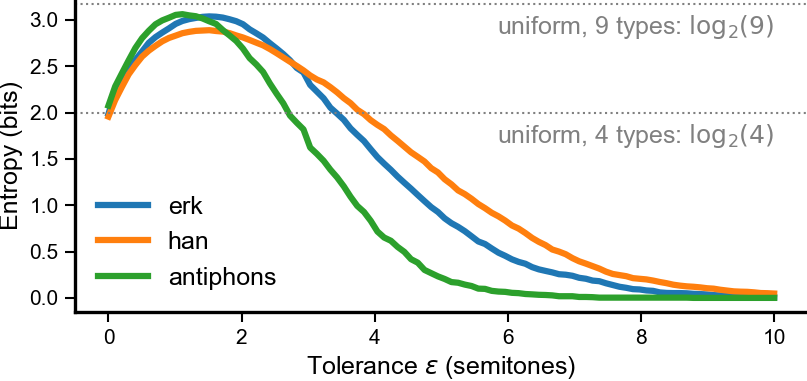

In [5]:
plt.figure(figsize=cm2inch(8, 3.5))

plt.plot(xs, losses['erk'], label='erk')
plt.plot(xs, losses['han'], label='han')
plt.plot(xs, losses['liber-antiphons'], label='antiphons')

plt.ylabel('Entropy (bits)')
plt.xlabel('Tolerance $\epsilon$ (semitones)');
plt.axhline(np.log2(4), ls=':', c='0.5', lw=.5)
plt.text(10, np.log2(4)-.1, 'uniform, 4 types: $\log_2(4)$', 
         va='top', ha='right', c='0.5', fontsize=6)
plt.axhline(np.log2(9), ls=':', c='0.5', lw=.5)
plt.text(10, np.log2(9)-.1, 'uniform, 9 types: $\log_2(9)$', 
         va='top', ha='right', c='0.5', fontsize=6)
sns.despine()
plt.legend()
# plt.savefig(f'../figures/figC1-entropies.pdf')

In [69]:
order = {
    'descending': 'desc',
    'horizontal-descending': 'h-desc',
    'convex': 'convex',
    'descending-horizontal': 'desc-h',
    'horizontal': 'horiz',
    'ascending-horizontal': 'asc-h',
    'concave': 'concave',
    'ascending': 'asc',
    'horizontal-ascending': 'h-asc',
}

In [70]:
freqs['descending']

0.294

## Panel A

In [110]:
def get_freqs(epsilons, contours):
    distributions = np.zeros((len(epsilons), 9))
    for i, epsilon in enumerate(epsilons):
        T = HuronTypology(tolerance=epsilon)
        contour_types = [T.classify(c) for c in contours]
        freqs = pd.value_counts(contour_types, normalize=True)
        distributions[i, :] = [freqs.get(t, 0) for t in order.keys()]

    freqs = pd.DataFrame(distributions, columns=order.keys()).T
    return freqs

In [171]:
epsilons = np.linspace(0, 12, 10)
freqs = get_freqs(epsilons, erk_contours)

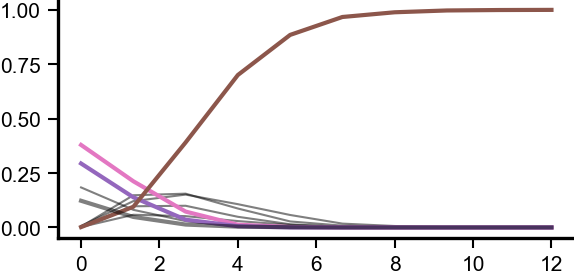

In [123]:
def show_freqs(epsilons, freqs):
    for label, ys in freqs.iterrows():
        if label not in ['horizontal', 'descending', 'convex', 'concave']:
            plt.plot(epsilons, ys, 'k-', lw=.5, ms=4, alpha=.5)
    plt.plot(epsilons, freqs.loc['convex', :], '-', lw=1, color='C6', label='convex')
    plt.plot(epsilons, freqs.loc['descending', :], '-', lw=1, color='C4', label='descending')
    plt.plot(epsilons, freqs.loc['horizontal', :], '-', lw=1, color='C5', label='horizontal')
    plt.plot(epsilons, freqs.loc['concave', :], 'k-', lw=1, ms=4, alpha=.5, label='others')

plt.figure(figsize=(2,1))
show_freqs(epsilons, freqs)

## Entropy panel

In [136]:
loss_fn = huron_optimizer.loss_function(erk_contours[:1000], ['tolerance'])
xs = np.linspace(0, epsilons[-1], 100)
losses = [-1*loss_fn([x]) for x in xs]

In [145]:
best, res = huron_optimizer.optimize(erk_contours[:1000], dict(tolerance=[0, 10]))
best_entropy = -1*res['fun']
best_epsilon = best['tolerance']

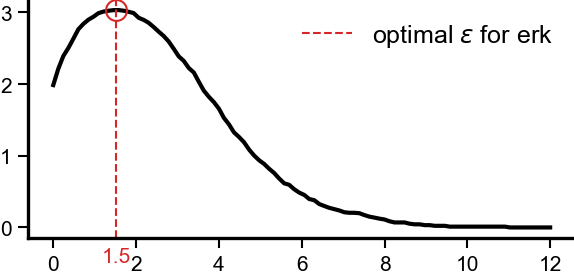

In [167]:
def show_entropy(xs, losses, best_epsilon, best_entropy):
    plt.plot(xs, losses, 'k-', lw=1)
    plt.plot(best_epsilon, best_entropy, 'o', markerfacecolor="None", ms=5, color='C3', markeredgewidth=.5)
    plt.axvline(best_epsilon, ls='--', color='C3', lw=.5, label='optimal $\epsilon$ for erk')
    plt.gca().text(best_epsilon, -.27, f'{best_epsilon:.1f}', color='C3', va='top', ha='center', size=5)
    plt.legend()

plt.figure(figsize=(2,1))
show_entropy(xs, losses, best_epsilon, best_entropy)

In [169]:
## Panel B

/Users/bas/repos/papers/contour-typology/env/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


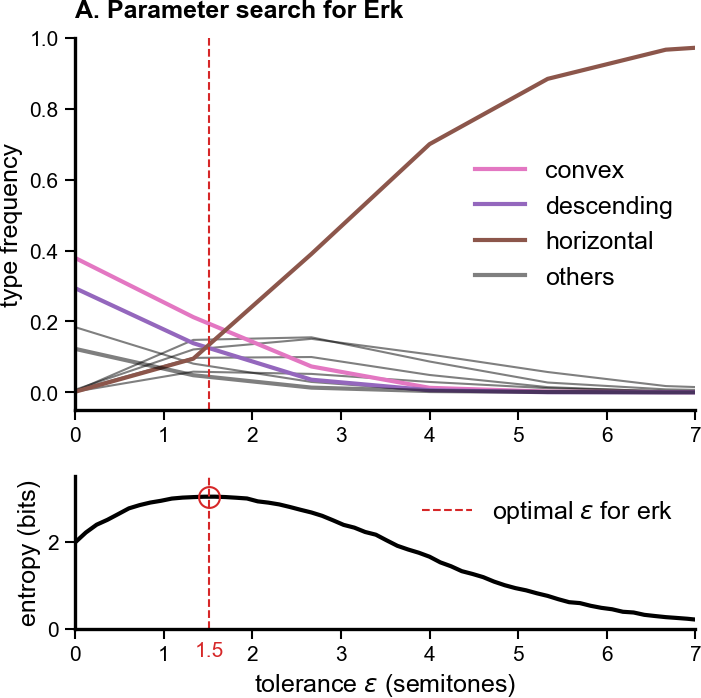

In [166]:
plt.figure(figsize=cm2inch(12,6.5))

# Frequencies
ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
show_freqs(epsilons, freqs)
plt.axvline(best_epsilon, ls='--', color='C3', lw=.5)
plt.ylim(-.05, 1)
plt.xlim(0, 7)
plt.ylabel('type frequency')
plt.title('A. Parameter search for Erk', ha='left', x=0)
plt.legend()

ax2 = plt.subplot2grid((3, 2), (2, 0), sharex=ax1)
show_entropy(xs, losses, best_epsilon, best_entropy)
plt.ylim(0, 3.5)
plt.ylabel('entropy (bits)')
plt.xlabel('tolerance $\epsilon$ (semitones)')

plt.tight_layout()

# TODO: CONTINUE HERE: ADD THE BAR PLOTS